In [1]:
# all tensorflow api is accessible through this
import tensorflow as tf        
# to visualize the resutls
import matplotlib.pyplot as plt 
# 70k mnist dataset that comes with the tensorflow container
from tensorflow.examples.tutorials.mnist import input_data

tf.set_random_seed(0)

# load data
mnist = input_data.read_data_sets('input/fashion', one_hot=True)

Extracting input/fashion/train-images-idx3-ubyte.gz
Extracting input/fashion/train-labels-idx1-ubyte.gz
Extracting input/fashion/t10k-images-idx3-ubyte.gz
Extracting input/fashion/t10k-labels-idx1-ubyte.gz


In [13]:
# 1. Define Variables and Placeholders
X = tf.placeholder(tf.float32, [None, 28 * 28 * 1])
Y_ = tf.placeholder(tf.float32, [None, 10]) # correct answers(labels)

XX = tf.reshape(X, [-1, 28, 28, 1])

#define weight variable for a convolutional layer
W_1 = tf.Variable(tf.truncated_normal([5, 5, 1, 4], stddev=0.1))
#define convolutional layer in model
B_1 = tf.Variable(tf.constant(0.1, shape=[4]))
Y_1 = tf.nn.relu(tf.nn.conv2d(XX, W_1, strides=[1, 1, 1, 1], padding='SAME') + B_1)

W_2 = tf.Variable(tf.truncated_normal([5, 5, 4, 8], stddev=0.1))
B_2 = tf.Variable(tf.constant(0.1, shape=[8]))
Y_2 = tf.nn.relu(tf.nn.conv2d(Y_1, W_2, strides=[1, 2, 2, 1], padding='SAME') + B_2)

W_3 = tf.Variable(tf.truncated_normal([4, 4, 8, 12], stddev=0.1))
B_3 = tf.Variable(tf.constant(0.1, shape=[12]))
Y_3 = tf.nn.relu(tf.nn.conv2d(Y_2, W_3, strides=[1, 2, 2, 1], padding='SAME') + B_3)

# placeholder for probability of keeping a node during dropout = 1.0 at test time (no dropout) and 0.75 at 
# training time
pkeep = tf.placeholder(tf.float32)

Y_3Y = tf.reshape(Y_3, [-1, 7 * 7 * 12]) 

W_fc1 = tf.Variable(tf.truncated_normal([7 * 7 * 12, 1000], stddev=0.1))
B_fc1 = tf.Variable(tf.constant(0.1, shape=[1000]))
Y_fc1 = tf.nn.relu(tf.matmul(Y_3Y, W_fc1) + B_fc1)

Y_fc1d = tf.nn.dropout(Y_fc1, pkeep)

W_fc2 = tf.Variable(tf.truncated_normal([1000, 10], stddev=0.1))
B_fc2 = tf.Variable(tf.constant(0.1, shape=[10]))

Ylogits = tf.matmul(Y_fc1d, W_fc2) + B_fc2
Y = tf.nn.softmax(Ylogits)

# 3. Define the loss function
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=Ylogits, labels=Y_) # calculate cross-entropy with logits
cross_entropy = tf.reduce_mean(cross_entropy)

# 4. Define the accuracy 
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Y,1), tf.argmax(Y_,1)), tf.float32))

# 5. Define an optimizer
#learning rate placeholder
global_step = tf.Variable(0, trainable=False)

SR = tf.placeholder(tf.float32)
Step = tf.placeholder(tf.float32)
Exp = tf.placeholder(tf.float32)

lr = tf.train.exponential_decay(SR, global_step, Step, Exp, staircase=True)

#train_step = tf.train.GradientDescentOptimizer(lr).minimize(cross_entropy, global_step=global_step)
#train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
#train_step = tf.train.AdamOptimizer(0.005).minimize(cross_entropy)
train_step = tf.train.AdamOptimizer(lr).minimize(cross_entropy, global_step=global_step)
#train_step = tf.train.AdamOptimizer(lr).minimize(cross_entropy, global_step=global_step)

# initialize
sess = tf.Session()

def training_step(args):
    
    pkeep_, SR_, Step_, Exp_ = args
    
    ####### actual learning 
    # reading batches of 100 images with 100 labels
    batch_X, batch_Y = mnist.train.next_batch(100)
    # the backpropagation training step
    sess.run(train_step, feed_dict={X: batch_X, Y_: batch_Y, pkeep: pkeep_, SR: SR_, Step: Step_, Exp: Exp_})
    #sess.run(train_step, feed_dict={X: batch_X, Y_: batch_Y, pkeep: 0.75})

    ####### evaluating model performance for printing purposes
    # evaluation used to later visualize how well you did at a particular time in the training
    train_a, train_c = sess.run([accuracy, cross_entropy], feed_dict={X: batch_X, Y_: batch_Y, pkeep: 1.0}) 
    
    return (train_a, train_c)


# 6. Train and test the model, store the accuracy and loss per iteration

train_a = []
train_c = []
test_a = []
test_c = []
cv_a = []
cv_c = []

cv_X, cv_Y = mnist.train.next_batch(8000)

def objective(args):
    global train_a, train_c, test_a, test_c
    
    sess.run(tf.global_variables_initializer())
    
    training_iter = 10000
    epoch_size = 100
    epsilon = 0.00005
    list_len = 20
    
    a = 0
    a_list = []
    a_old = 0
    
    c = 0
    ta = 0
    tc = 0
    
    for i in range(training_iter):
        a, c, = training_step(args)
        print "\r", i,
        
        ## Kommentera bort
        a_list.append(a)
        
        if len(a_list) > list_len: 
            a_list.pop(0)
            
            avg = reduce(lambda x, y: x + y, a_list) / len(a_list)
            
            if (abs(avg - a_old) < epsilon): 
                break
        
            a_old = a
        ## Tills hit
        
    train_a.append(a)
    train_c.append(c)
            
    ta, tc = sess.run([accuracy, cross_entropy], feed_dict={X: mnist.test.images, Y_: mnist.test.labels, pkeep: 1.0})        
    test_a.append(ta)
    test_c.append(tc)
             
    ca, cc = sess.run([accuracy, cross_entropy], feed_dict={X: cv_X, Y_: cv_Y, pkeep: 1.0}) 
    cv_a.append(ca)
    cv_c.append(cc)
            
    return ca

import itertools

def frange(x, y, jump):
    while x < y:
        yield x
        x += jump

space = [
    frange(0.7000001, 0.90000001, 0.1000001),   # pkeep
    frange(0.0006000001, 0.0012000001, 0.0003000001), # SR 
    frange(50.000001, 150.000001, 50.000001),   # Step
    frange(0.90000001, 0.98000001, 0.04000001)  # Exp
]

permutations = list(itertools.product(*space))
print len(permutations)

cnt = 1
a = 0
conf = None

for p in permutations:
    temp = objective(p)
    print "\n\r  ", p, temp, cnt,
    if temp > a:
        a = temp
        conf = p
        print "\r  ", conf, a, "new max",
    cnt += 1

print "\n", a, conf


16
49             
139 0.7000001, 0.0006000001, 50.000001, 0.90000001) 0.741375 new max                                      
449 0.7000001, 0.0006000001, 50.000001, 0.9400000199999999) 0.784 new max                                                                                                                    

KeyboardInterrupt: 

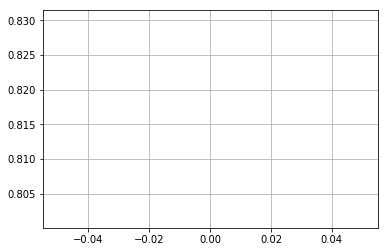

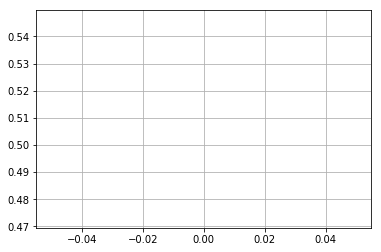

NameError: name 'training_iter' is not defined

In [9]:
# 7. Plot and visualise the accuracy and loss

# accuracy training vs testing dataset
plt.plot(train_a)
plt.plot(test_a)
plt.grid(True)
plt.show()

# loss training vs testing dataset
plt.plot(train_c)
plt.plot(test_c)
plt.grid(True)
plt.show()

# Zoom in on the tail of the plots
zoom_point = 50
x_range = range(zoom_point,training_iter/epoch_size)
plt.plot(x_range, train_a[zoom_point:])
plt.plot(x_range, test_a[zoom_point:])
plt.grid(True)
plt.show()

plt.plot(train_c[zoom_point:])
plt.plot(test_c[zoom_point:])
plt.grid(True)
plt.show()